## Test technique - Descartes Underwriting

Samuel Brasil de Albuquerque

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

In [2]:
# Read Files

## Les deux derniers fichiers (SHELL_AUTO et MEAN_AUTO) ne sont pas utiles pour ce projet. 
## Ils peuvent donc être intégralement ignorés.

test_set  = pd.read_csv("test_auto.csv" )
train_set = pd.read_csv("train_auto.csv")

print("train dataset has", len(train_set), "lines")
print("test dataset has" , len(test_set ), "lines")

print()

print("train dataset has", len(train_set.columns), "columns")
print("test dataset has", len(test_set.columns), "columns")

train dataset has 8161 lines
test dataset has 2141 lines

train dataset has 26 columns
test dataset has 26 columns


### Clean data

In [3]:
def money_to_float(df, columns):
    to_strip = "$"
    to_remove = ","
    
    for col in columns:
        df[col] = df[col].str.strip(to_strip)
        df[col] = df[col].str.replace(to_remove, "")
        df[col] = df[col].replace(np.nan, 0)
        df[col] = df[col].astype(float)
    
def clean_binary(df, columns):
    for col in columns:
        df[col] = df[col].replace({'M': 1, 'z_F': 0, 'Yes': 1, 'yes': 1,'z_No': 0, 'no': 0, 'No':0, 'Private': 0, 'Commercial' : 1,
                                  'z_Highly Rural/ Rural': 0, 'Highly Urban/ Urban': 1})
        
def clean_education(df):
    col = "EDUCATION"
    df[col] = df[col].replace({'<High School': 0, 'z_High School': 1, 'Bachelors': 2, 'Masters': 3, 'PhD': 4})
    
def clean_job(df):
    col = "JOB"
    df[col] = df[col].replace({np.nan: 0, 'Student': 1, 'Home Maker': 2, 'Clerical': 3,'Professional': 4,
                               'Manager': 5, 'Doctor': 6, 'Lawyer': 7,'z_Blue Collar':8})
    
def clean_car_type(df):
    col = "CAR_TYPE"
    df[col] = df[col].replace({'Minivan': 0, 'Van': 1, 'Panel Truck': 2, 'z_SUV': 3, 
                               'Pickup': 4, 'Sports Car': 5})   
    
def clean_nan(df, columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mean())
        #df[col] = df[col].replace({np.nan: 0})      

In [4]:
train_set.dtypes

## features to clean
features = ["INCOME", "PARENT1", "HOME_VAL", "MSTATUS", "SEX", "EDUCATION", "JOB", "CAR_USE", "BLUEBOOK", 
            "CAR_TYPE", "RED_CAR", "OLDCLAIM", "REVOKED", "URBANICITY"]

In [5]:
# Money to float

money_ft = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]

money_to_float(train_set, money_ft)
money_to_float(test_set, money_ft)

## clean binary features

bin_features = ["SEX", "PARENT1", "MSTATUS", "RED_CAR", "REVOKED", "CAR_USE", "URBANICITY"]

clean_binary(train_set, bin_features)
clean_binary(test_set, bin_features)

## clean education

clean_education(train_set)
clean_education(test_set)

## clean job

clean_job(train_set)
clean_job(test_set)

## clean car type

clean_car_type(train_set)
clean_car_type(test_set)

## clean nan columns

columns_nan = ["AGE", "YOJ", "CAR_AGE"]

clean_nan(train_set, columns_nan)
clean_nan(test_set, columns_nan)

### Here we verify consistency of the targets

In [6]:
## VERIFY: if TARGET_AMT > 0, TARGET_FLAG=1 otherwise TARGET_FLAG=0

ver_1 = (len(train_set[['TARGET_FLAG']].loc[train_set['TARGET_AMT'] > 0]) == sum(train_set['TARGET_FLAG'].loc[train_set['TARGET_AMT'] > 0]))
print("All non 0 target_amt have target_flag = 1:", ver_1)

## VERIFY: if TARGET_FLAG = 0 then TARGET_FLAG = 0

ver_2 = (max(train_set['TARGET_AMT'].loc[train_set['TARGET_FLAG'] == 0]) == 0)
print("All the 0 target_flag have target_amt = 0:", ver_2)

All non 0 target_amt have target_flag = 1: True
All the 0 target_flag have target_amt = 0: True


### We look for strong covariances

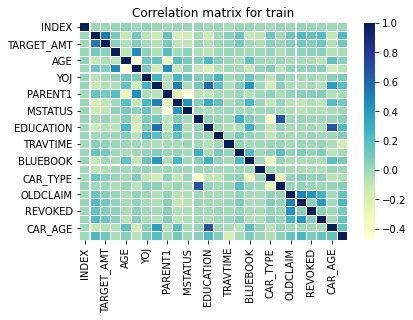

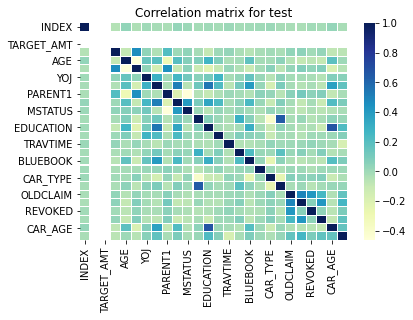

In [7]:
# Calculating Correlation between features
corrmat_train = train_set.corr()   
corrmat_test  = test_set.corr( )   

# Visualizing Correlation between every feature
f0, ax1 = plt.subplots() 
sns.heatmap(corrmat_train, ax = ax1, cmap ="YlGnBu", linewidths = 0.1)
ax1.set_title("Correlation matrix for train")
plt.show()

f1, ax2 = plt.subplots() 
sns.heatmap(corrmat_test, ax = ax2, cmap ="YlGnBu", linewidths = 0.1)
ax2.set_title("Correlation matrix for test")
plt.show()

### Data Visualisation - PCA - Looking for clusters

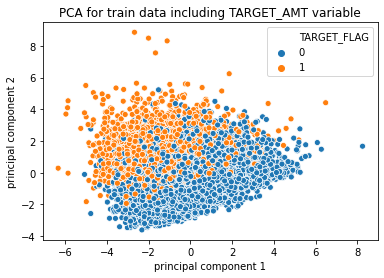

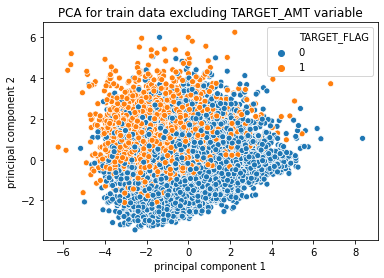

In [8]:
features = train_set.columns

# Separating out the features
X = StandardScaler().fit_transform(train_set.loc[:, features].values)

c = train_set["TARGET_FLAG"]

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Plot
x = principalDf['principal component 1']
y = principalDf['principal component 2']
ax = sns.scatterplot(x = x, y = y,hue = c)
ax.set_title("PCA for train data including TARGET_AMT variable")
plt.legend()
plt.show()

features_x = [col for col in train_set.columns if col not in ['TARGET_AMT']]

X1 = StandardScaler().fit_transform(train_set.loc[:, features_x].values)

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X1)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Plot
x1 = principalDf['principal component 1']
y1 = principalDf['principal component 2']
ax = sns.scatterplot(x = x1, y = y1,hue = c)
ax.set_title("PCA for train data excluding TARGET_AMT variable")
plt.legend()
plt.show()

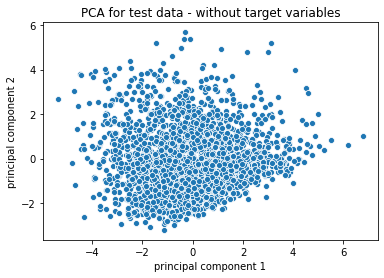

In [9]:
features_test = [col for col in test_set.columns if col not in ['TARGET_AMT', 'TARGET_FLAG']]

X2 = StandardScaler().fit_transform(test_set.loc[:, features_test].values)

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X2)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Plot
x_test = principalDf_test['principal component 1']
y_test = principalDf_test['principal component 2']
ax = sns.scatterplot(x = x_test, y = y_test)
ax.set_title("PCA for test data - without target variables")
plt.show()

We have no clusters

### Classification test

We are going to use a (MLP) neuron network and a logistic regression classifier to classificate the variables and evaluate it with the accuracy function below to choose the best method

In [10]:
def accuracy(a,b):
    s = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            s += 1
    return s/len(a)

In [11]:
## we divide randomly the train data set in the subsets train and test to evaluate the algorithm

train, test = train_test_split(train_set, test_size=0.3)

## we separate them in X, y_flag and y_amt

X_train = train[[feature for feature in train.columns if feature not in ['TARGET_FLAG','TARGET_AMT']]].copy()
X_test  = test[[feature for feature in train.columns if feature not in ['TARGET_FLAG','TARGET_AMT']]].copy()

y_train_amt = train[['TARGET_AMT']].copy()
y_test_amt  = test[['TARGET_AMT']].copy()

y_train_flag = train[['TARGET_FLAG']].copy()
y_test_flag  = test[['TARGET_FLAG']].copy()

In [12]:
### MLP Classifier
clf = MLPClassifier(random_state=1, max_iter=1000)
clf.fit(X_train, y_train_flag['TARGET_FLAG'])

y_test_flag_clf = clf.predict(X_test)
print("MLP Accuracy: {}".format(accuracy(y_test_flag['TARGET_FLAG'].array, y_test_flag_clf)))

### Logistic regression classifier
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train_flag['TARGET_FLAG'])

y_test_flag_clf = clf.predict(X_test)
print("LR Accuracy: {}".format(accuracy(y_test_flag['TARGET_FLAG'].array, y_test_flag_clf)))


MLP Accuracy: 0.5896284197631686
LR Accuracy: 0.7333605553287056


Since sometimes they have a similar accuracy, we'll run several times.

In [13]:
def best_classifier(n):
    
    MLP = []
    LR = []
    
    for i in range(n):
        ## we divide randomly the train data set in the subsets train and test to evaluate the algorithm

        train, test = train_test_split(train_set, test_size=0.3)

        ## we separate them in X, y_flag and y_amt

        X_train = train[[feature for feature in train.columns if feature not in ['TARGET_FLAG','TARGET_AMT']]].copy()
        X_test  = test[[feature for feature in train.columns if feature not in ['TARGET_FLAG','TARGET_AMT']]].copy()

        y_train_amt = train[['TARGET_AMT']].copy()
        y_test_amt  = test[['TARGET_AMT']].copy()

        y_train_flag = train[['TARGET_FLAG']].copy()
        y_test_flag  = test[['TARGET_FLAG']].copy()
        
        ### MLP Classifier
        clf = MLPClassifier(random_state=1, max_iter=1000)
        clf.fit(X_train, y_train_flag['TARGET_FLAG'])

        y_test_flag_clf = clf.predict(X_test)
        MLP.append(accuracy(y_test_flag['TARGET_FLAG'].array, y_test_flag_clf))

        ### Logistic regression classifier
        clf = LogisticRegression(random_state=0, max_iter=1000)
        clf.fit(X_train, y_train_flag['TARGET_FLAG'])

        y_test_flag_clf = clf.predict(X_test)
        LR.append(accuracy(y_test_flag['TARGET_FLAG'].array, y_test_flag_clf))
        
    plt.plot(MLP, label = "MLP")
    plt.plot(LR, label = "LR")
    plt.legend()
    plt.show()



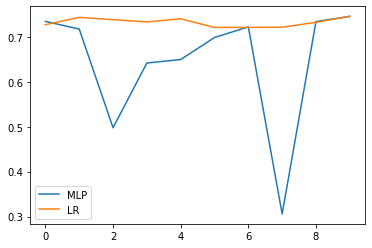

In [14]:
best_classifier(10)

### We choose the LR classifier since it's more stable and more accurate

In [15]:
X = train_set[[feature for feature in train_set.columns if feature not in ['TARGET_FLAG','TARGET_AMT']]].copy()
y = train_set[['TARGET_FLAG']].copy()

X_test = test_set[[feature for feature in test_set.columns if feature not in ['TARGET_FLAG','TARGET_AMT']]].copy()

In [16]:
### Logistic regression classifier
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X, np.ravel(y))

y_test = clf.predict(X_test)

y_test = pd.DataFrame(y_test)
y_test = y_test.rename(columns={0: 'TARGET_FLAG'})

In [17]:
### Create csv

## csv with the test data and predictions
X_test["TARGET_FLAG"] = y_test
X_test.to_csv("data_and_prediction.csv")

## csv just with the predictions
y_test.to_csv("only_prediction.csv")